## NDSI（Normalized Difference Snow Index）とは

NDSIは雪を判定するために2つのバンド帯の差を取り、値を正規化したものである。
これは、雪の分光反射特性が波長 0.6㎛（緑）付近で高く、波長 1.5 ㎛（中間赤外）付近で低いことを利用している。

緑波長（G）と中間赤外波長（SWIR）を用いて、

`NDSI = (G - SWIR) / (G + SWIR)` 

と計算される。
閾値は一般的に 0.4 あたりが利用され、閾値以上の場合は積雪、閾値以下は非積雪と判定する。 

（とはいえ今回のALOSの光学画像には、R, G, B, NIR の4band帯しかないため、SWIRを使わずに、NDSIに近いものを調査する。。。）

似た指標には以下がある。

* NDVI: Normalized Difference Vegetation Index（正規化植生指数）
* NDWI: Normalized Difference Water Index（正規化水指数）

NDVIは植生の分布状況や活性度を示す指標で、近赤外波長(NIR）と赤波長(R)を用いて、 `NDVI = (NIR-R) / (NIR+R)` で計算される。NDVIの値が大きくなるほど植生が濃いと判断される。 

NDWIは地表面における水の存在と深い関連をもつ指標の1つで、赤波長（R）と中間赤外波長（SWIR）を用いて、 `NDWI =(R-SWIR)/(R+SWIR)` で計算される。NDWIの値が大きくなるほど表面が帯水状況にあると判断される。


In [1]:
import numpy as np
from skimage import io
from skimage import color
from skimage import img_as_ubyte
from skimage import filters
import matplotlib.pyplot as plt
%matplotlib inline

# OPF-APIからのデータ取得

In [2]:
#APIのドメイン
URL_DOMAIN="https://img.opf-dev.jp"

# # 富士山（雪が一番わかりやすいため）
Z=13
X=7252
Y=3234

In [3]:
def read_img(img_type, domain=URL_DOMAIN, z=Z, x=X, y=Y):
    return io.imread("{}/{}/{}/{}/{}.png".format(domain, img_type, Z, X, Y))

img_osm = read_img("osm")
img_band1= read_img("av2ori/band1").astype('int32')
img_band2 = read_img("av2ori/band2").astype('int32')
img_band3 = read_img("av2ori/band3").astype('int32')
img_band4 = read_img("av2ori/band4").astype('int32')
img_true = np.c_[img_band3[:,:,0:1], img_band2[:,:,1:2], img_band1[:,:,2:3]]

Band1 = 青
Band2 = 緑
Band3 = 赤
Band4 = 近赤外線

/opt/conda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


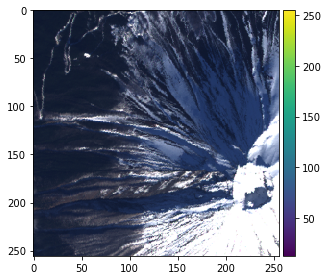

In [4]:
#元画像確認
io.imshow(img_true)

## NDSI の検証

`NDSI = (G - SWIR) / (G + SWIR)` 
としたいところだが、 `SWIR` がないので代わりに `NIR` を使い検証

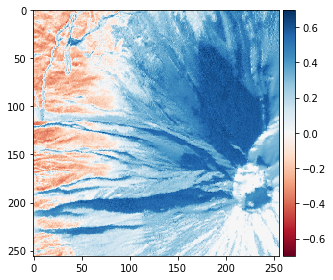

In [5]:
img_NDSI = (img_band2[:,:,1] - img_band4[:,:,1])  / (img_band2[:,:,1] + img_band4[:,:,1])
io.imshow(img_NDSI)

それっぽいが右下が完全に黒くなってしまっており、成功とは言い難い。
band4の代わりに、それぞれband1,3でも検証。

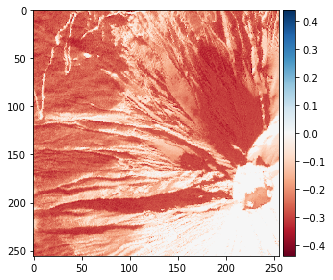

In [6]:
img_NDSI =  ((img_band2[:,:,1] - img_band1[:,:,2]) ) / (img_band2[:,:,1] + img_band1[:,:,2])
io.imshow(img_NDSI)

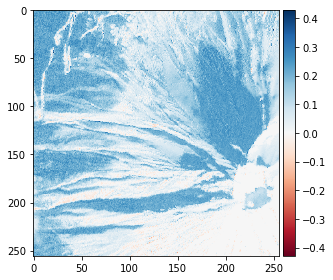

In [7]:
img_NDSI =  ((img_band2[:,:,1] - img_band3[:,:,0]) ) / (img_band2[:,:,1] + img_band3[:,:,0])
io.imshow(img_NDSI)

それ以外にも、band4を固定した組み合わせも確認

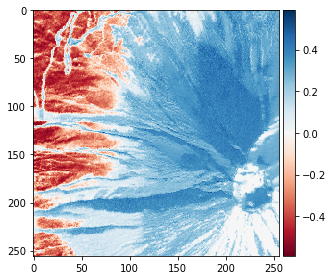

In [8]:
# band3とband4
img_NDSI =  (img_band3[:,:,0] - img_band4[:,:,0]) / (img_band3[:,:,0] + img_band4[:,:,0])
io.imshow(img_NDSI)

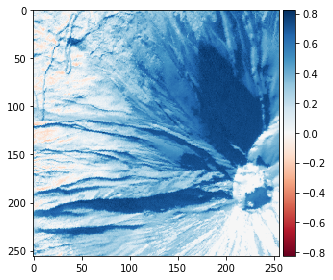

In [9]:
# band1とband4
img_NDSI =  (img_band1[:,:,2] - img_band4[:,:,0]) / (img_band1[:,:,2] + img_band4[:,:,0])

io.imshow(img_NDSI)

band4が植物判定に使えることもあり、band4を使うとそこそこそれっぽいのが出ていることがわかります。

band2-band4 を利用し閾値の判定を行います。

## NDSI の閾値調査

まずヒストグラムで分布を確認

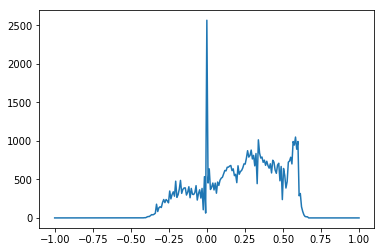

In [10]:
img_NDSI =  (img_band2[:,:,1] - img_band4[:,:,1])  / (img_band2[:,:,1] + img_band4[:,:,1])
hists, bins=np.histogram(img_NDSI, 255, [-1, 1])
plt.plot(np.linspace(-1, 1, 255), hists)

2つのバンドの値が同じで、値が0になっているケースが一番多い

二つの山を分けるように、0.2を閾値にして分類

/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


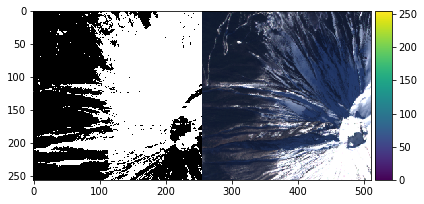

In [11]:
img_NDSI =  (img_band3[:,:,0] - img_band4[:,:,0]) / (img_band3[:,:,0] + img_band4[:,:,0])

height, width= img_NDSI.shape
img_binary = np.zeros((height, width)) # 0で初期化
img_binary = img_NDSI > 0.2 # 閾値にもとづいて2値化
io.imshow(np.concatenate((color.gray2rgb(img_binary*255), img_true), axis=1))

今回のSWIRを使わないNDSIモドキでは、あまり正しく抽出できなそうである。

## HSV画像の明度で雪かどうかの2値を判定し、NDSIを使いグラデーションをつける

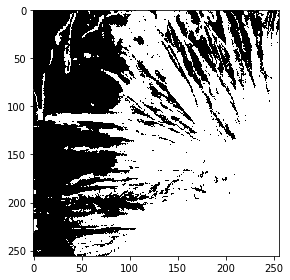

In [12]:
# RGB画像からHSV画像への変換
img_hsv = color.rgb2hsv(img_true.astype("uint8"))
img_v = img_hsv[:,:,2]

height, width= img_v.shape
img_binary = np.zeros((height, width)) # 0で初期化
img_binary = img_v > 70 / 255 # 閾値にもとづいて2値化

io.imshow(img_binary)

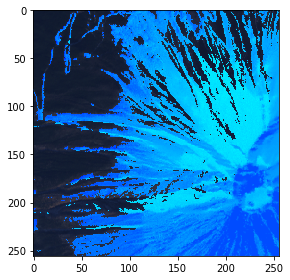

In [13]:
img_NDSI =  (img_band2[:,:,1] - img_band4[:,:,1]) / (img_band2[:,:,1] + img_band4[:,:,1])

#明度を使って雪部分をマスキング
img_msk = img_true.copy()
img_msk[img_binary] = 0

#雪部分にNDSIを使ってグラデーションをかける（水色になるほど雪が深く、濃い青になるほど雪が薄い）
height, width= img_binary.shape
img_ndsi_grad = np.zeros((height, width, 3)) # 0で初期化
img_ndsi_grad[:,:,0] = 0
img_ndsi_grad[:,:,1] = (img_NDSI + 0.3 ) * 255 #値が0~255になるように修正
img_ndsi_grad[:,:,2] = 255
img_ndsi_grad[~img_binary] = 0

#2つの画像を合成
img_ndsi_grad_msk  = img_ndsi_grad + img_msk

io.imshow(img_ndsi_grad_msk.astype("uint8"))